# Дерево Решений

## Описание алгоритма и основные шаги

Дерево решений — тип контролируемого машинного обучения, который в основном используется в задачах классификации. По сути это жадное (так как на каждом шаге выбирается наилучшее разбиение), нисходящее, рекурсивное разбиение. Сверху вниз, так как выполнение начинается с корневого узла, где находятся все записи, а затем делается разбиение.

Рассмотрим принцип работы алгоритма на схеме:
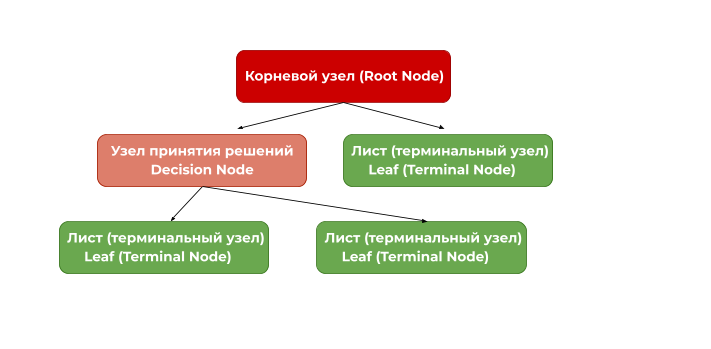

Корневой узел — самый верхний узел в дереве решений. Узел принятия решения — подузел, который разделяется на дополнительные подузлы. Лист (терминальный узел) — узел, который не разделяется на другие узлы.

### Набор данных

Рассмотрим пример применения дерева решений из библиотеки Scikit-learn для синтетических данных. Два класса будут сгенерированы из двух нормальных распределений с разными средними.

In [1]:
from __future__ import division, print_function
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
%matplotlib inline
import numpy as np 
import pandas as pd 

Задача классификации в этом случае – построить какую-то "хорошую" границу, разделяющую 2 класса (голубые точки от фиолетовых).

In [2]:
# первый класс
np.seed = 7
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# добавляем второй класс
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

## Представление набора данных

Рассмотрим как данные изначально распределены на графике: 

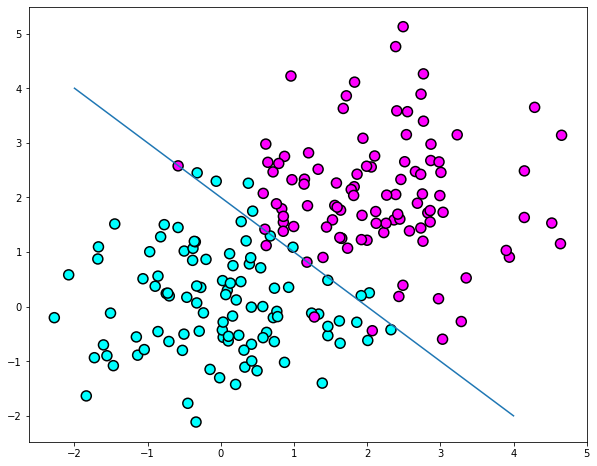

In [3]:
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='cool', edgecolors='black', linewidth=1.5);
plt.plot(range(-2,5), range(4,-3,-1));

Как можно увидеть, провести четкую границу решений нельзя, все данные разбросаны. Принцип работы дерева решений заключается в разбивке данных до того момента, пока не станет видна четкая граница решений. Поэтому на следующих шагах мы ее визуализируем.

### Применение энтропии

Энтропия — это мера случайности или неопределенности. Уровень энтропии колеблется от 0 до 1. Когда энтропия равна 0, это означает, что подмножество чистое, то есть в нем нет случайных элементов. Когда энтропия равна 1, это означает высокую степень случайности. Энтропия обозначается символами H(S).

$ H(S) = -P(0) * \log_2P(0)\ - P(1) * \log_2P(1)\ $

P(0) - Вероятность принадлежности к классу 0.
P(1) - Вероятность принадлежности к классу 1.

### Связь между энтропией и вероятностью

Если P(0) = 1 и P(1) = 0, то энтропия равна 0. Если P(1) = 1 и P(0) = 0, то энтропия равна 0. Если P(0) = 0.5 и P(1) = 0.5, то энтропия равна 1.

Когда энтропия равна 0, это означает, что в подмножестве нет энтропии: либо все «да», либо все голоса «нет». Когда она равна 1, то это означает высокую степень случайности.

## Пример использования энтропии

Рассмотрим, как с помощью энтропии можно обнаружить ключевые признаки для разбиения. Будем предсказывать цвет шарика по координате.
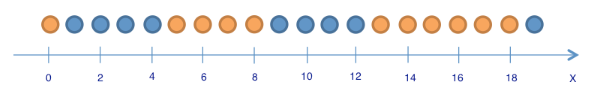

In [49]:
import math
P0 = 9/20; P1 = 11/20
HS0 = -(P0 * math.log(P0, 2) + P1 * math.log(P1, 2))
print(HS0)

0.9927744539878084


Мы получили первый результат, теперь разобьем шарики на 2 группы: если их координата не меньше или больше 12. Распишем сначала для 1 кучки, затем для 2.
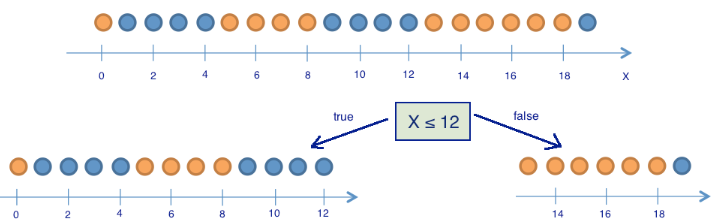

In [1]:
import math #1 кучка <= 12
P0 = 8/13; P1 = 5/13
HS1 = -(P0 * math.log(P0, 2) + P1 * math.log(P1, 2))
print(HS1)

0.961236604722876


In [51]:
import math #2 кучка > 12
P0 = 1/7; P1 = 6/7
HS2 = -(P0 * math.log(P0, 2) + P1 * math.log(P1, 2))
print(HS2)

0.5916727785823275


Энтропия уменьшилась в обеих группах по сравнению с начальным состоянием, хоть в левой и не сильно. Поскольку энтропия – по сути степень хаоса (или неопределенности) в системе, уменьшение энтропии называют приростом информации. 

### Информационный выигрыш

Информационный выигрыш для разбиения рассчитывается путем вычитания взвешенных энтропий каждой ветви из исходной энтропии. Используем его для принятия решения о порядке расположения атрибутов в узлах дерева решений.

$ Gain(S, A) = H(S) - \sum_{V \in Values(A)} \frac{|S_{V}|}{|S|}H(S_{V}) $

H(S) - Энтропия;
A - Атрибут;
S - Множество примеров X;
V - Возможные значения A;
Sv - Подмножество.

Рассмотрим информационный выигрыш для нашей задачи

In [52]:
HS0 = 0.99277; HS1 = 0.9612; HS2 = 0.5916
Gain = HS0 - 13/20 * HS1 - 7/20 * HS2
print(Gain)

0.16093000000000005


Рассмотрим полный цикл работы дерева, до тех пора пока мы не получим терминальные листы (то есть деление невозможно).
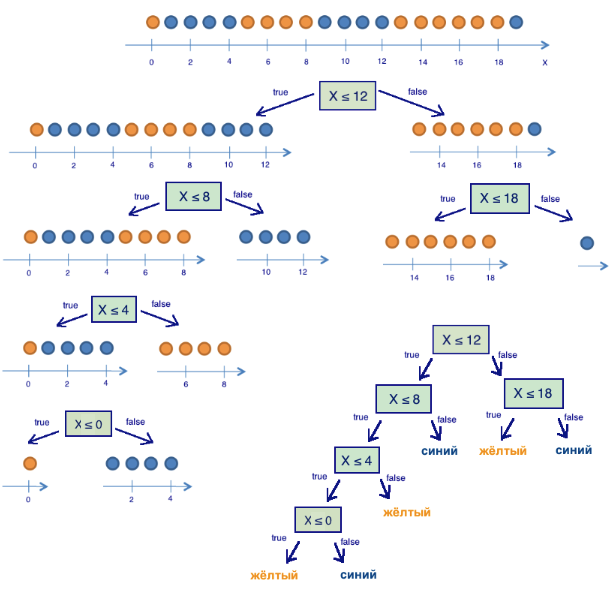

В основе популярных алгоритмов построения дерева решений лежит принцип жадной максимизации прироста информации – на каждом шаге выбирается тот признак, при разделении по которому прирост информации оказывается наибольшим. Дальше процедура повторяется рекурсивно, пока энтропия не окажется равной нулю или какой-то малой величине.

## Построение и анализ модели

In [53]:
from sklearn.tree import DecisionTreeClassifier

# Вспомогательная функция, возвращающая решетку для визуализации
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

In [54]:
# параметр min_samples_leaf указывает, при каком минимальном количестве элементов в узле он будет дальше разделяться
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

#обучение дерева
clf_tree.fit(train_data, train_labels)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

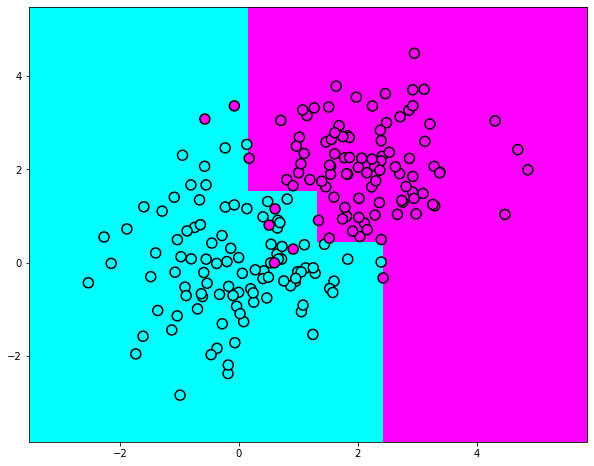

In [55]:
# отображение разделяющей поверхности
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='cool')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='cool', edgecolors='black', linewidth=1.5)

# Пример работы с конкретными данными

Попробуем предсказать, является ли банкнота подлинной или поддельной в зависимости от четырех различных атрибутов изображения банкноты. К атрибутам относятся дисперсия вейвлет-преобразованного изображения, эксцесс изображения, энтропия и асимметрия изображения.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
dataset = pd.read_csv("data_banknote_authentication.txt")
dataset.head()

,Variance of Wavelet Transformed image,Skewness of Wavelet Transformed image,Curtosis of Wavelet Transformed image,Entropy of image,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


Разделим данные на атрибуты и метки.

In [62]:
X = dataset.drop('Class', axis=1)
y = dataset['Class']

Переменная X содержит все столбцы из набора данных, кроме столбца "Класс", который является меткой. Переменная y содержит значения из столбца "Класс".

In [64]:
X = dataset.drop('Class', axis=1)
y = dataset['Class']

Заключительный этап предварительной обработки состоит в том, чтобы разделить данные на обучающие и тестовые наборы. Библиотека model_selection содержит метод train_test_split , который мы будем использовать для случайного разделения данных на обучающие и тестовые наборы. 

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

### Обучение и составление прогнозов

После разделения данных необходимо обучить алгоритм дерева решений на этих данных и сделать прогнозы. Scikit-Learn содержит библиотеку tree, которая содержит встроенные классы/методы для различных алгоритмов дерева решений. 

In [66]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

DecisionTreeClassifier()

Сделаем прогнозы по тестовым данным. Для составления прогнозов используется метод predict класса Decision Tree Classifier

In [1]:
y_pred = classifier.predict(X_test)

NameError: name 'classifier' is not defined

### Оценка алгоритма

Посмотрим, насколько точен алгоритм. Библиотека Scikit-Learn metrics содержит методы classification_report и confusion_matrix , которые могут быть использованы для оценки.

In [68]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[157   1]
 [  1 116]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       158
           1       0.99      0.99      0.99       117

    accuracy                           0.99       275
   macro avg       0.99      0.99      0.99       275
weighted avg       0.99      0.99      0.99       275

